In [1]:
print('hi')

hi


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [4]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [5]:
# Download NLTK VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ansarafsar","key":"bc231c7b7d5b81ebfbe8e1191c79fe2b"}'}

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [8]:
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 85.5MB/s]


In [9]:
!unzip twitter-entity-sentiment-analysis.zip -d /content/data

Archive:  twitter-entity-sentiment-analysis.zip
  inflating: /content/data/twitter_training.csv  
  inflating: /content/data/twitter_validation.csv  


In [40]:
# Load the training and validation datasets
train_cols = ['ID', 'Topic', 'Sentiment', 'Text']
df_train = pd.read_csv('/content/data/twitter_training.csv', names=train_cols)
df_val = pd.read_csv('/content/data/twitter_validation.csv', names=train_cols)
print(df_train)
print ("*********************************************************************************************")
print(df_val)

         ID        Topic Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   
...     ...          ...       ...   
74677  9200       Nvidia  Positive   
74678  9200       Nvidia  Positive   
74679  9200       Nvidia  Positive   
74680  9200       Nvidia  Positive   
74681  9200       Nvidia  Positive   

                                                    Text  
0      im getting on borderlands and i will murder yo...  
1      I am coming to the borders and I will kill you...  
2      im getting on borderlands and i will kill you ...  
3      im coming on borderlands and i will murder you...  
4      im getting on borderlands 2 and i will murder ...  
...                                                  ...  
74677  Just realized that the Windows partition of my...  
74678  Just realized that my Mac window partition is ...  
74679  Just 

In [45]:
print(df_train.columns)
print(df_val.columns)

Index(['ID', 'Topic', 'Sentiment', 'Text'], dtype='object')
Index(['ID', 'Topic', 'Sentiment', 'Text'], dtype='object')


In [11]:
# Display the first few rows of the training dataset
print("Training Dataset:")
print(df_train.head())

Training Dataset:
     ID        Topic Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                Text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [12]:
print("\nValidation Dataset:")
print(df_val.head())


Validation Dataset:
     ID      Topic   Sentiment  \
0  3364   Facebook  Irrelevant   
1   352     Amazon     Neutral   
2  8312  Microsoft    Negative   
3  4371      CS-GO    Negative   
4  4433     Google     Neutral   

                                                Text  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is slapping Americans in the...  


In [13]:
# Basic information about the datasets
print("\nTraining Dataset Info:")
df_train.info()
print("\nValidation Dataset Info:")
df_val.info()


Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB

Validation Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   Topic      1000 non-null   object
 2   Sentiment  1000 non-null   object
 3   Text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [14]:
# Check for missing values in both datasets
print("\nMissing Values in Training Dataset:")
print(df_train.isna().sum())
print("\nMissing Values in Validation Dataset:")
print(df_val.isna().sum())


Missing Values in Training Dataset:
ID             0
Topic          0
Sentiment      0
Text         686
dtype: int64

Missing Values in Validation Dataset:
ID           0
Topic        0
Sentiment    0
Text         0
dtype: int64


In [15]:
# Drop missing values
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)

In [16]:
# Initialize VADER Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [17]:
# Function to get sentiment scores
def get_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores

In [18]:
# Apply the function to the 'Text' column in both datasets
df_train['Sentiment_Scores'] = df_train['Text'].apply(get_sentiment)
df_val['Sentiment_Scores'] = df_val['Text'].apply(get_sentiment)

In [19]:
# Extract compound scores for simplicity
df_train['Compound'] = df_train['Sentiment_Scores'].apply(lambda score_dict: score_dict['compound'])
df_val['Compound'] = df_val['Sentiment_Scores'].apply(lambda score_dict: score_dict['compound'])

In [20]:
# Classify sentiment based on compound score
df_train['Sentiment_Pred'] = df_train['Compound'].apply(lambda c: 'Positive' if c >= 0.05 else ('Negative' if c <= -0.05 else 'Neutral'))
df_val['Sentiment_Pred'] = df_val['Compound'].apply(lambda c: 'Positive' if c >= 0.05 else ('Negative' if c <= -0.05 else 'Neutral'))

In [21]:
# Display the first few rows to see the new columns in the training set
print("\nTraining Dataset with Predictions:")
print(df_train.head())


Training Dataset with Predictions:
     ID        Topic Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                Text  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                    Sentiment_Scores  Compound Sentiment_Pred  
0  {'neg': 0.37, 'neu': 0.63, 'pos': 0.0, 'compou...   -0.6908       Negative  
1  {'neg': 0.343, 'neu': 0.657, 'pos': 0.0, 'comp...   -0.6908       Negative  
2  {'neg': 0.37, 'neu': 0.63, 'pos': 0.0, 'compou...   -0.6908       Negative  
3  {'neg': 0.37, 'neu': 0.63, 'pos': 0.0, 'compou...   -0.6908       Negative  
4  {'neg': 0.343, 'neu

In [22]:
# Visualizations for Training Dataset
sentiment_counts = df_train['Sentiment'].value_counts()

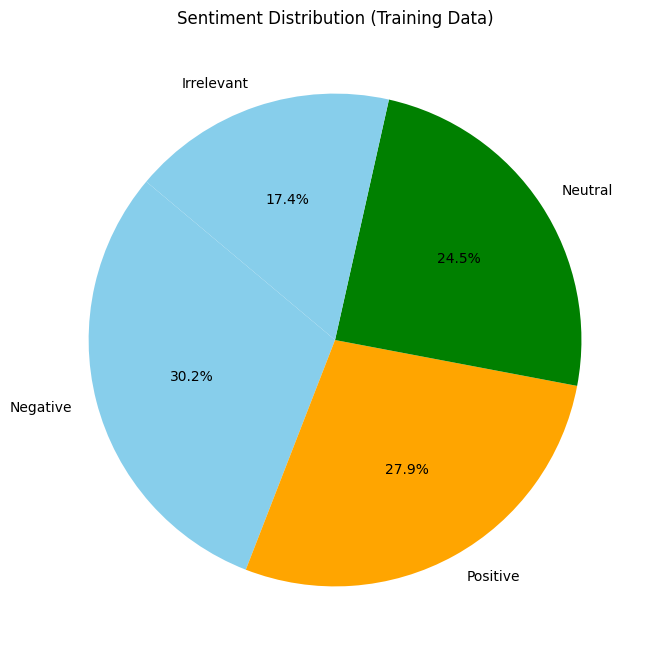

In [23]:
# Pie chart for sentiment distribution
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", startangle=140, colors=['skyblue', 'orange', 'green'])
plt.title('Sentiment Distribution (Training Data)')
plt.show()

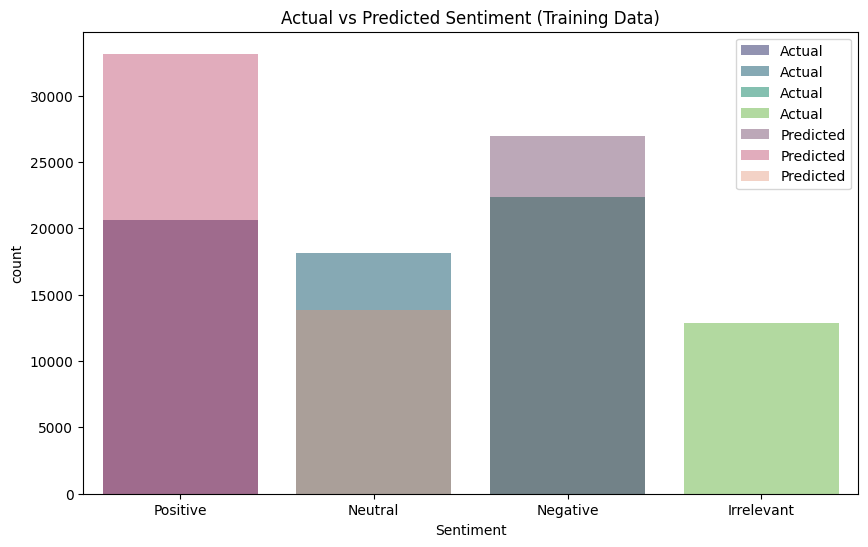

In [24]:
# Compare actual sentiment with predicted sentiment for training set
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df_train, palette='viridis', alpha=0.6, label='Actual')
sns.countplot(x='Sentiment_Pred', data=df_train, palette='rocket', alpha=0.4, label='Predicted')
plt.title('Actual vs Predicted Sentiment (Training Data)')
plt.legend()
plt.show()

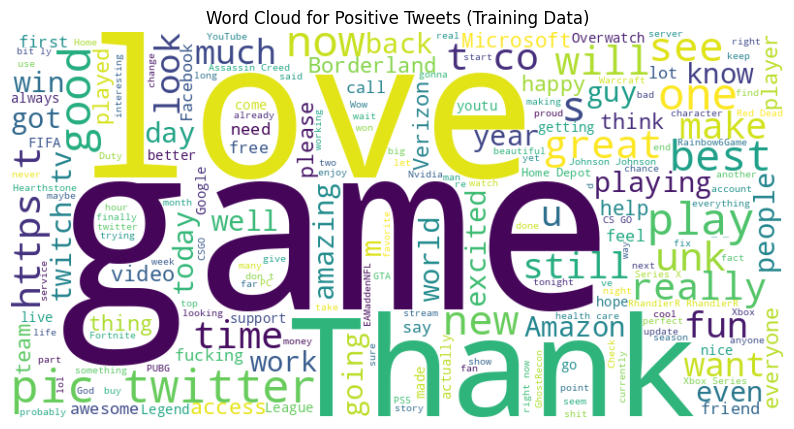

In [25]:
# Word Cloud for positive tweets in training set
positive_tweets = ' '.join(df_train[df_train['Sentiment_Pred'] == 'Positive']['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Tweets (Training Data)')
plt.axis('off')
plt.show()

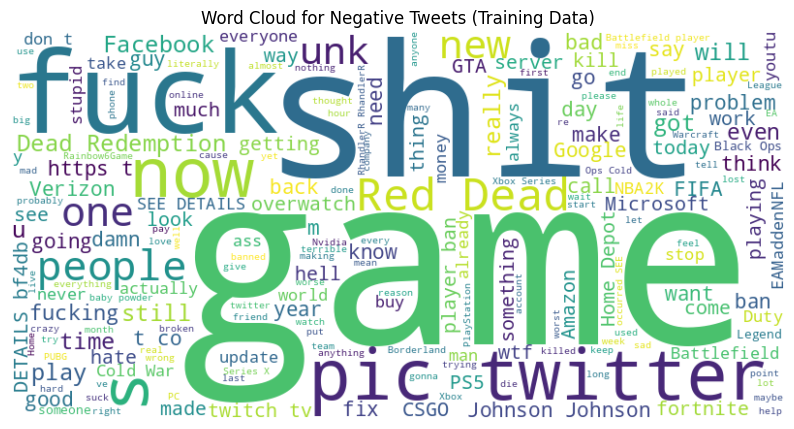

In [26]:
# Word Cloud for negative tweets in training set
negative_tweets = ' '.join(df_train[df_train['Sentiment_Pred'] == 'Negative']['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Tweets (Training Data)')
plt.axis('off')
plt.show()

In [27]:
# Feature Engineering: Create additional features for training set
df_train['Tweet_Length'] = df_train['Text'].apply(len)

In [28]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(df_train['Text'])

In [29]:
# Training the Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_vectorized, df_train['Sentiment'])

LogisticRegression(max_iter=1000)

In [31]:
# Predictions for validation set
X_val_vectorized = vectorizer.transform(df_val['Text'])  # Vectorize validation data
y_pred_val = logreg.predict(X_val_vectorized)

In [32]:
# Evaluation on validation set
print("Validation Classification Report:\n", classification_report(df_val['Sentiment'], y_pred_val))

Validation Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.93      0.90      0.92       172
    Negative       0.89      0.95      0.92       266
     Neutral       0.95      0.91      0.93       285
    Positive       0.92      0.92      0.92       277

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



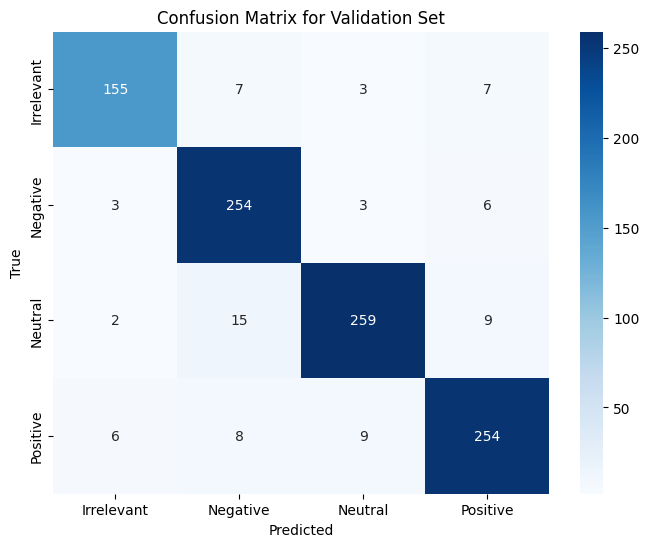

In [33]:
# Confusion Matrix for Validation Set
cm_val = confusion_matrix(df_val['Sentiment'], y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.title('Confusion Matrix for Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

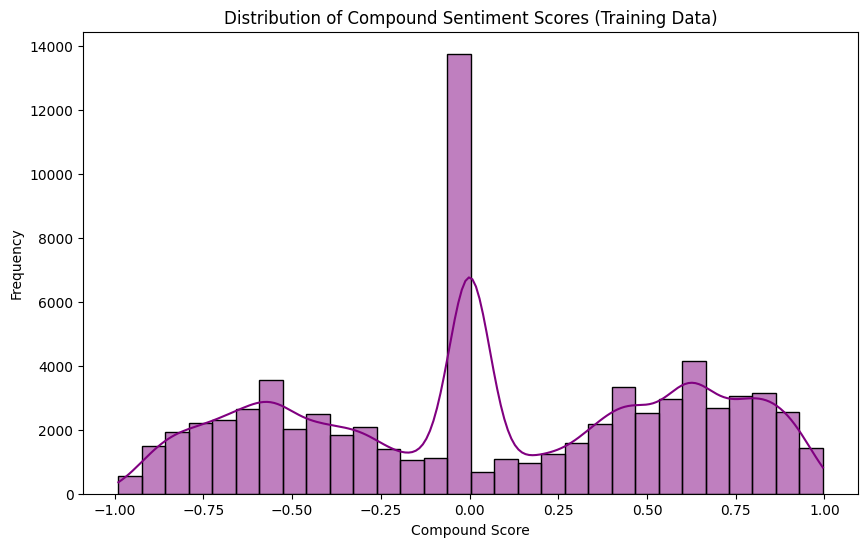

In [34]:
# Statistical Analysis
# Display distribution of compound scores for training dataset
plt.figure(figsize=(10, 6))
sns.histplot(df_train['Compound'], bins=30, kde=True, color='purple')
plt.title('Distribution of Compound Sentiment Scores (Training Data)')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

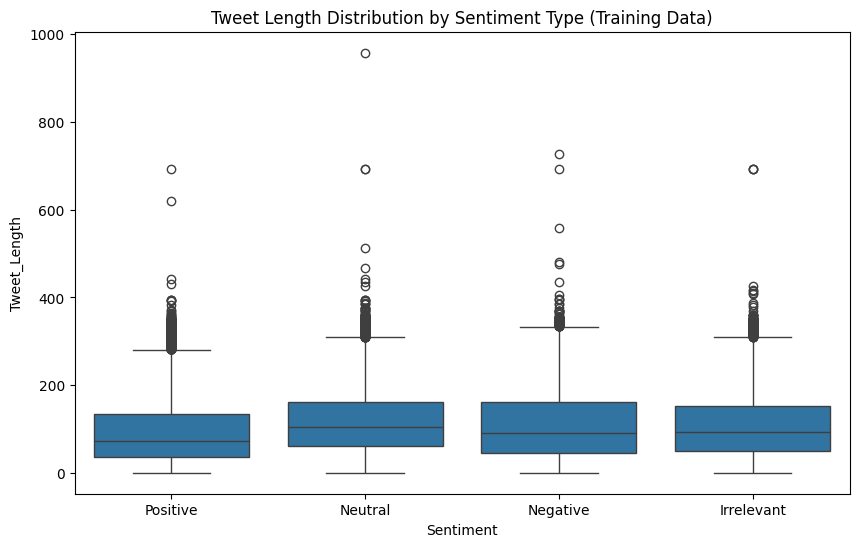

In [35]:
# Boxplot for tweet length by sentiment in training dataset
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='Tweet_Length', data=df_train)
plt.title('Tweet Length Distribution by Sentiment Type (Training Data)')
plt.show()

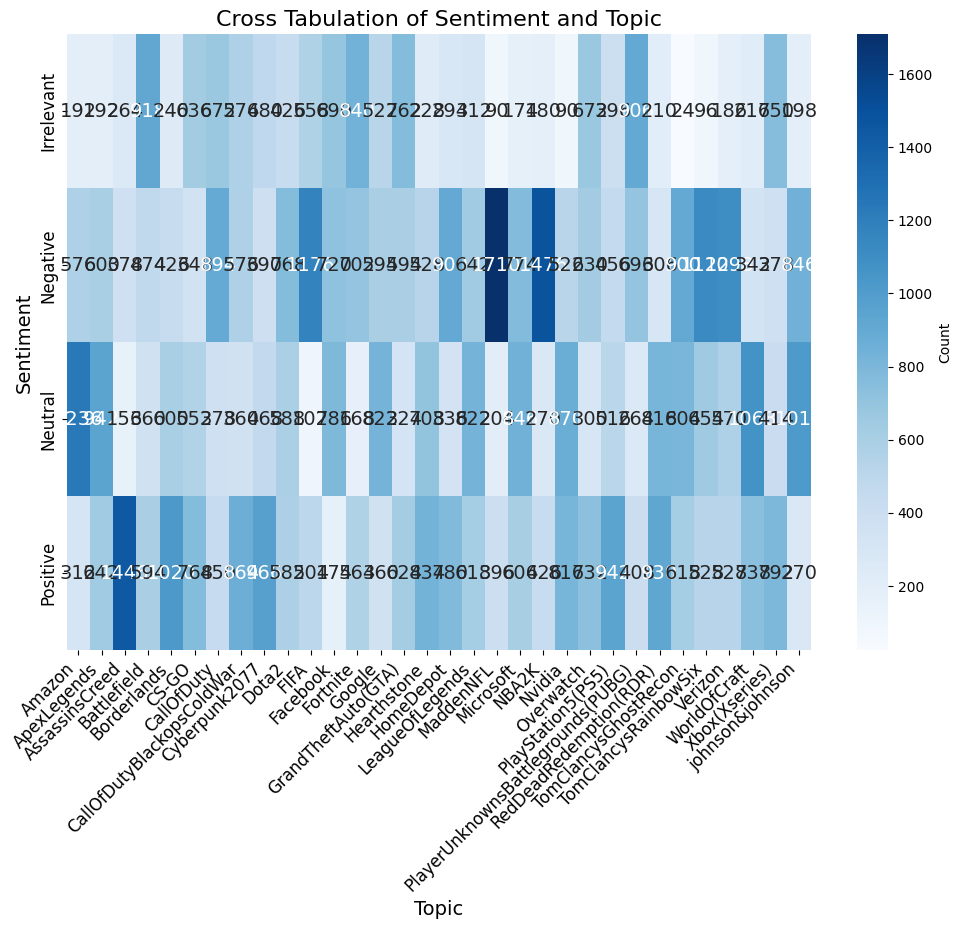

In [48]:
# Cross Tabulation
cross_tab = pd.crosstab(df_train['Sentiment'], df_train['Topic'])

# Visualize Cross Tabulation
plt.figure(figsize=(12, 8))  # Increase the figure size
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            annot_kws={"size": 14})  # Adjust annotation font size
plt.title('Cross Tabulation of Sentiment and Topic', fontsize=16)  # Adjust title font size
plt.xlabel('Topic', fontsize=14)  # Adjust x-axis label font size
plt.ylabel('Sentiment', fontsize=14)  # Adjust y-axis label font size
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)  # Adjust y-axis label font size
plt.show()
